# Monte Carlo Methods in Reinforcement Learning

This notebook demonstrates Monte Carlo methods for reinforcement learning, which learn value functions and optimal policies from experience through sampling.

## Learning Objectives
By the end of this notebook, you will understand:
- How Monte Carlo methods learn from complete episodes
- The difference between first-visit and every-visit Monte Carlo
- How to implement Monte Carlo control algorithms
- The exploration vs exploitation trade-off in Monte Carlo methods
- Why Monte Carlo methods work well for episodic tasks

## Key Concepts
- **Monte Carlo Prediction**: Learning value functions from sample returns
- **Monte Carlo Control**: Learning optimal policies through exploration
- **Exploration Strategies**: Epsilon-greedy and other exploration methods
- **Episode-based Learning**: Learning from complete sequences of experience

---

<a href="https://colab.research.google.com/github/xhxuciedu/CS175/blob/master/notebooks/monte_carlo_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and Installation

**Note:** This notebook does not require a GPU, so make sure the runtime type is set to CPU to lower your Colab usage.

In [ ]:
%%capture
!pip install 'gymnasium[box2d]'
# !pip install matplotlib numpy

In [ ]:
# imports
import gymnasium as gym
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# actions
LEFT, DOWN, RIGHT, UP = 0,1,2,3

# import the frozen lake gymnasium environment
name = 'FrozenLake-v1'
env = gym.make(name, is_slippery=False) # warning: setting slippery=True results in very complex environment dynamics where the optimal solution does not make sense to humans!

# Set up environment with proper seeding
observation, info = env.reset(seed=742)
env.action_space.seed(742)

# Add nS and nA attributes for compatibility with dynamic programming algorithms
env.nS = env.observation_space.n
env.nA = env.action_space.n

[742]

In [ ]:
# helper function to draw the frozen lake
def plot(V,policy,col_ramp=1,dpi=175,draw_vals=False):
    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams.update({'axes.edgecolor': (0.32,0.36,0.38)})
    plt.rcParams.update({'font.size': 4 if env.env.nrow == 8 else 7})
    plt.figure(figsize=(3,3))
    plt.imshow(1-V.reshape(env.env.nrow,env.env.ncol)**col_ramp, cmap='gray', interpolation='none', clim=(0,1))
    ax = plt.gca()
    ax.set_xticks(np.arange(env.env.ncol)-.5)
    ax.set_yticks(np.arange(env.env.nrow)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    for s in range(env.nS):
        x = s%env.env.nrow
        y = int(s/env.env.ncol)
        a = policy[s]
        gray = np.array((0.32,0.36,0.38))
        if env.desc.tolist()[y][x] == b'G':
            plt.text(x-0.45,y-0.3, 'goal', color=(0.75,0.22,0.17), fontname='Sans', weight='bold')
            continue
        if a[0] > 0.0: plt.arrow(x, y, float(a[0])*-.84, 0.0, color=gray+0.2*(1-V[s]), head_width=0.1, head_length=0.1) # left
        if a[1] > 0.0: plt.arrow(x, y, 0.0, float(a[1])*.84,  color=gray+0.2*(1-V[s]), head_width=0.1, head_length=0.1) # down
        if a[2] > 0.0: plt.arrow(x, y, float(a[2])*.84, 0.0,  color=gray+0.2*(1-V[s]), head_width=0.1, head_length=0.1) # right
        if a[3] > 0.0: plt.arrow(x, y, 0.0, float(a[3])*-.84, color=gray+0.2*(1-V[s]), head_width=0.1, head_length=0.1) # up
        if env.desc.tolist()[y][x] == b'F': plt.text(x-0.45,y-0.3, 'ice', color=(gray*V[s]), fontname='Sans')
        if env.desc.tolist()[y][x] == b'S': plt.text(x-0.45,y-0.3, 'start',color=(0.21,0.51,0.48), fontname='Sans', weight='bold')
        if draw_vals and V[s]>0:
            vstr = '{0:.1e}'.format(V[s]) if env.env.nrow == 8 else '{0:.6f}'.format(V[s])
            plt.text(x-0.45,y+0.45, vstr, color=(gray*V[s]), fontname='Sans')
    plt.grid(color=(0.42,0.46,0.48), linestyle=':')
    ax.set_axisbelow(True)
    ax.tick_params(color=(0.42,0.46,0.48),which='both',top='off',left='off',right='off',bottom='off')
    plt.show()

## Understanding Monte Carlo Methods

Monte Carlo methods learn from complete episodes of experience. Unlike dynamic programming, they don't require a model of the environment and can learn directly from interaction.

### Key Characteristics:
- **Model-free**: No need for transition probabilities
- **Episode-based**: Learn from complete sequences
- **Sample-based**: Use actual returns instead of expected returns
- **Incremental**: Update estimates after each episode

### The Monte Carlo Update Rule:
$$V(S_t) \leftarrow V(S_t) + \alpha[G_t - V(S_t)]$$

Where $G_t$ is the actual return from time $t$ to the end of the episode.

## Q-Learning vs Monte Carlo

Let's first see what happens with a naive Q-learning approach that doesn't explore properly.

In [ ]:
def random_epsilon_greedy_policy(Q, epsilon, state, nA):
    A = np.ones(nA, dtype=float) * epsilon / nA
    best_action = np.argmax(Q[state])
    A[best_action] += (1.0 - epsilon)
    return A

In [ ]:
Q = np.zeros([env.observation_space.n, env.action_space.n])
n_visits = np.zeros([env.observation_space.n, env.action_space.n])
num_episodes = 5000
epsilon = 0.4
stats = 0.0

for episode in range(num_episodes):
    state, info = env.reset()
    terminated = False
    truncated = False
    results_list = []
    result_sum = 0.0
    while not (terminated or truncated):
        action = np.argmax(Q[state, :])
        new_state, reward, terminated, truncated, _ = env.step(action)
        results_list.append((state, action))
        result_sum += reward
        state = new_state

    for (state, action) in results_list:
        n_visits[state, action] += 1.0
        alpha = 1.0 / n_visits[state, action]
        Q[state, action] += alpha * (result_sum - Q[state, action])

    stats += result_sum
    if episode % 500 == 0 and episode is not 0:
        print(f"success: {stats/episode}, epsilon: {epsilon}")

print(f"success: {stats/episode}, epsilon: {epsilon}")

env.close()

success: 0.0, epsilon: 0.4
success: 0.0, epsilon: 0.4
success: 0.0, epsilon: 0.4
success: 0.0, epsilon: 0.4
success: 0.0, epsilon: 0.4
success: 0.0, epsilon: 0.4
success: 0.0, epsilon: 0.4
success: 0.0, epsilon: 0.4
success: 0.0, epsilon: 0.4
success: 0.0, epsilon: 0.4


... it get's stuck in a local minima (never explores)

**Monte carlo learning** $\epsilon$-greedy exploration

In [ ]:
Q = np.zeros([env.observation_space.n, env.action_space.n])
n_s_a = np.zeros([env.observation_space.n, env.action_space.n])
num_episodes = 100000
epsilon = 0.4
stats = 0.0

for episode in range(num_episodes):
    state, info = env.reset()
    terminated = False
    truncated = False
    results_list = []
    result_sum = 0.0
    while not (terminated or truncated):
        if np.random.rand() > epsilon:
            action = np.argmax(Q[state, :])
        else:
            action = env.action_space.sample()
        new_state, reward, terminated, truncated, _ = env.step(action)
        results_list.append((state, action))
        result_sum += reward
        state = new_state

    for (state, action) in results_list:
        n_s_a[state, action] += 1.0
        alpha = 1.0 / n_s_a[state, action]
        Q[state, action] += alpha * (result_sum - Q[state, action])

    stats += result_sum
    if episode % 500 == 0 and episode is not 0:
        print(f"success: {stats/episode}, epsilon: {epsilon}")

print(f"success: {stats/episode}, epsilon: {epsilon}")

env.close()

success: 0.0, epsilon: 0.4
success: 0.0, epsilon: 0.4
success: 0.0, epsilon: 0.4
success: 0.0, epsilon: 0.4
success: 0.0, epsilon: 0.4
success: 0.0, epsilon: 0.4
success: 0.04742857142857143, epsilon: 0.4
success: 0.1065, epsilon: 0.4
success: 0.15244444444444444, epsilon: 0.4
success: 0.192, epsilon: 0.4
success: 0.224, epsilon: 0.4
success: 0.24766666666666667, epsilon: 0.4
success: 0.272, epsilon: 0.4
success: 0.29, epsilon: 0.4
success: 0.30706666666666665, epsilon: 0.4
success: 0.3185, epsilon: 0.4
success: 0.33176470588235296, epsilon: 0.4
success: 0.3427777777777778, epsilon: 0.4
success: 0.35336842105263155, epsilon: 0.4
success: 0.3622, epsilon: 0.4
success: 0.3698095238095238, epsilon: 0.4
success: 0.37781818181818183, epsilon: 0.4
success: 0.3863478260869565, epsilon: 0.4
success: 0.393, epsilon: 0.4
success: 0.39776, epsilon: 0.4
success: 0.40176923076923077, epsilon: 0.4
success: 0.4071111111111111, epsilon: 0.4
success: 0.4119285714285714, epsilon: 0.4
success: 0.41655172

In [ ]:
# lets just sample the maximum action from Q to show the optimal policy
def pi_star_from_Q(Q):
    terminated = False
    truncated = False
    pi_star = np.zeros([env.observation_space.n, env.action_space.n])
    state, info = env.reset() # start in top-left, = 0
    while not (terminated or truncated):
        action = np.argmax(Q[state, :])
        pi_star[state,action] = 1
        state, reward, terminated, truncated, _ = env.step(action)
    return pi_star

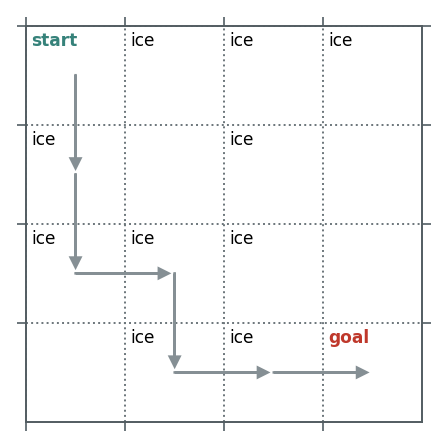

In [ ]:
plot(np.zeros_like(Q[:,0]), pi_star_from_Q(Q))

In [ ]:
Q

array([[0.17274819, 0.51755927, 0.40132226, 0.42316572],
       [0.17792422, 0.        , 0.56689325, 0.41541111],
       [0.39851485, 0.6182541 , 0.48088531, 0.53076269],
       [0.55873758, 0.        , 0.44646098, 0.44594595],
       [0.2756926 , 0.60405281, 0.        , 0.48259912],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.79745004, 0.        , 0.59353202],
       [0.        , 0.        , 0.        , 0.        ],
       [0.4112478 , 0.        , 0.70773892, 0.50395439],
       [0.5763133 , 0.82194713, 0.80038236, 0.        ],
       [0.70238095, 0.956698  , 0.        , 0.60544554],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.82538544, 0.95813428, 0.7219214 ],
       [0.81713675, 0.95807495, 1.        , 0.80070547],
       [0.        , 0.        , 0.        , 0.        ]])

**Now lets examine the exploration vs exploitation problem in a harder setting**

In [ ]:
# import the frozen lake gymnasium environment
name = 'FrozenLake8x8-v1'
env = gym.make(name, is_slippery=False) # warning: setting slippery=True results in very complex environment dynamics where the optimal solution does not make sense to humans!

# Set up environment with proper seeding
observation, info = env.reset(seed=742)
env.action_space.seed(742)

# Add nS and nA attributes for compatibility with dynamic programming algorithms
env.nS = env.observation_space.n
env.nA = env.action_space.n

[742]

**Greedy at the limit of infinite exploration**

Note this doesn't always converge to a very good policy for the 8x8 board! Try a few times and it should eventually discover an optimal policy.

In [ ]:
Q = np.zeros([env.observation_space.n, env.action_space.n])
n_s_a = np.zeros([env.observation_space.n, env.action_space.n])
stats = 0.0
num_episodes = 100000

for episode in range(num_episodes):
    state, info = env.reset()
    rAll = 0
    terminated = False
    truncated = False
    results_list = []
    result_sum = 0.0
    while not (terminated or truncated):
        epsilon = min(1.0, 1000.0/(episode+1))
        if np.random.rand() > epsilon:
            action = np.argmax(Q[state, :])
        else:
            action = env.action_space.sample()
        new_state, reward, terminated, truncated, _ = env.step(action)
        results_list.append((state, action))
        result_sum += reward
        state = new_state

    for (state, action) in results_list:
        n_s_a[state, action] += 1.0
        alpha = 1.0 / n_s_a[state, action]
        Q[state, action] += alpha * (result_sum - Q[state, action])

    stats += result_sum
    if episode % 5000 == 0 and episode is not 0:
        print(f"success: {stats/episode}, epsilon: {epsilon}")

print(f"success: {stats/episode}, epsilon: {epsilon}")

env.close()

success: 0.6876, epsilon: 0.0999900009999
success: 0.78185, epsilon: 0.04999750012499375
success: 0.8399333333333333, epsilon: 0.033332222259258026
success: 0.876525, epsilon: 0.02499937501562461
success: 0.899, epsilon: 0.01999960000799984
success: 0.9145, epsilon: 0.01666638889351844
success: 0.9256, epsilon: 0.014285510206997042
success: 0.934175, epsilon: 0.0124998437519531
success: 0.9408888888888889, epsilon: 0.011110987655692715
success: 0.946409464094641, epsilon: 0.01


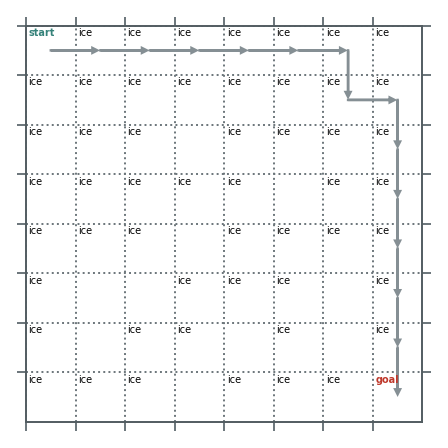

In [ ]:
plot(np.zeros_like(Q[:,0]), pi_star_from_Q(Q))

That's better, even in this larger game, it's still slow to converge and doesn't have good success rates though.